In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

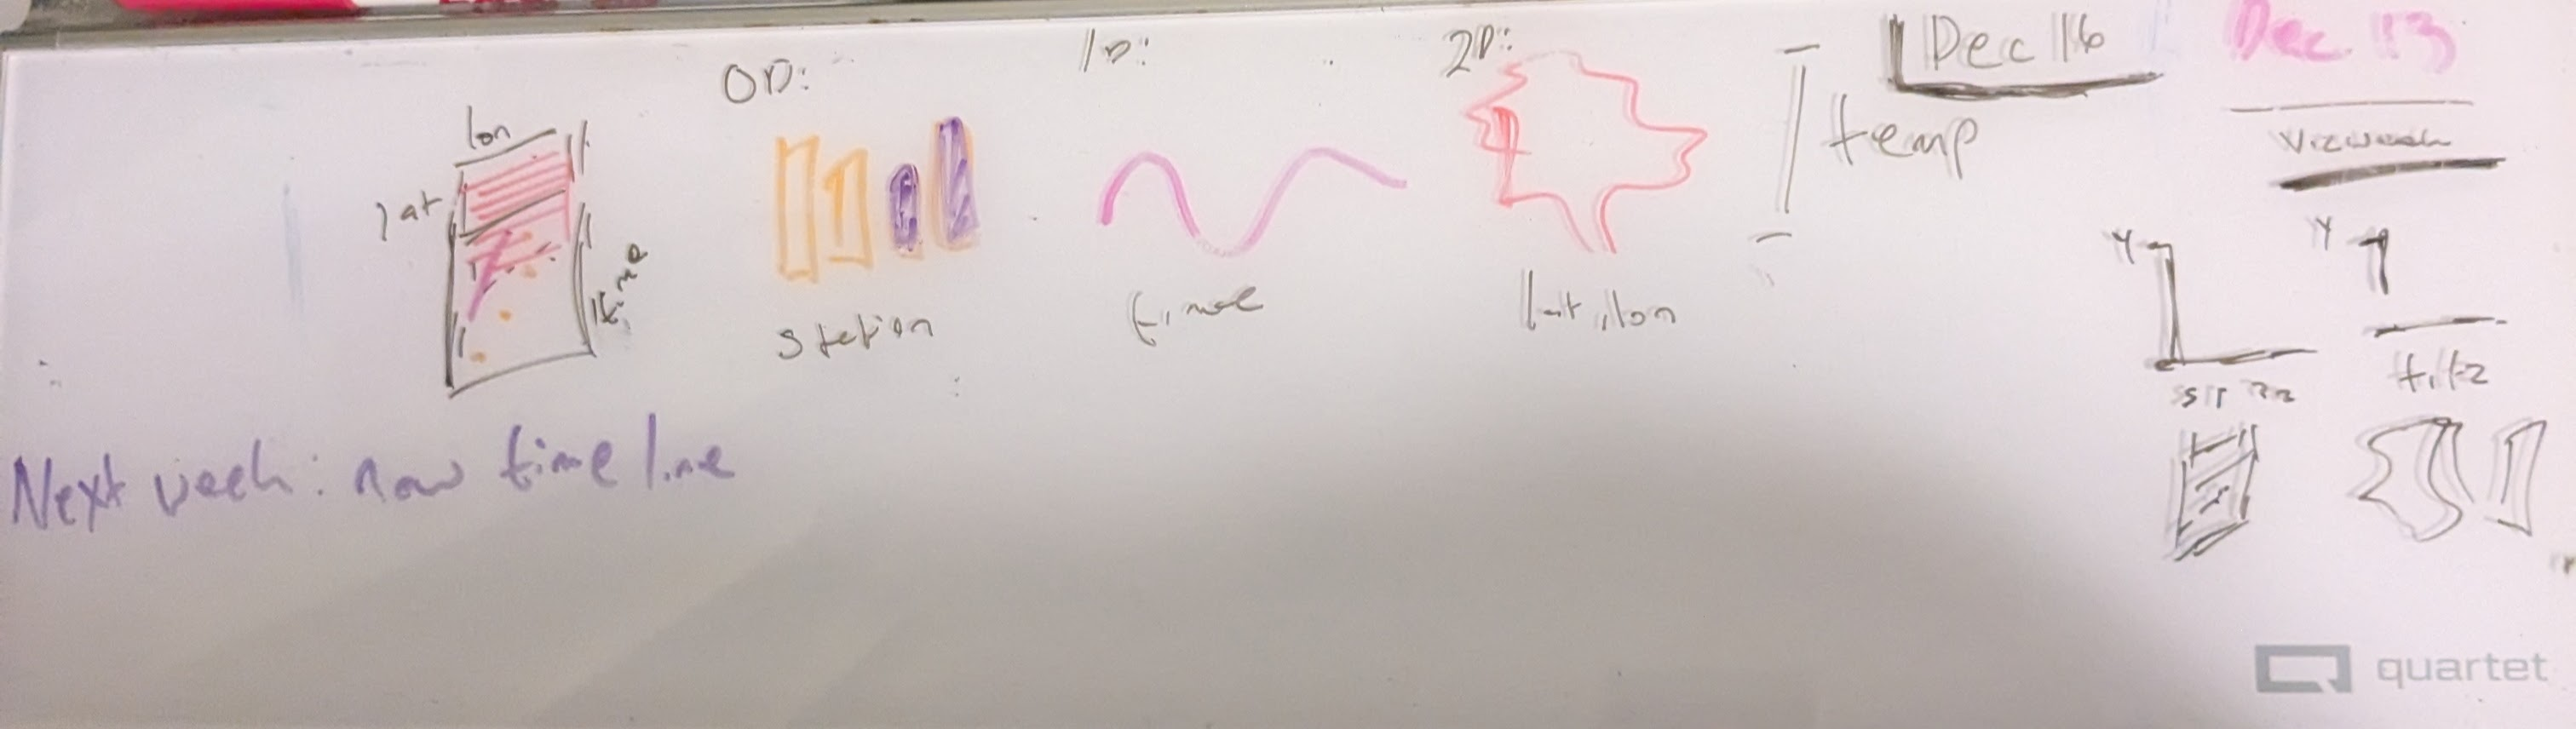

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import homeomorphism_helpers as hh


paper_path = Path('../figures/')

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np

import metpy
from metpy.interpolate import interpolate_to_grid

import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.text as mtext
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.transforms as mtransforms

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d import proj3d

import cmocean

import intro_plots as ip
import papercolors
from papercolors import colordict as pcd
from homeomorphism_helpers import fs, airports

In [5]:
data = hh.get_data("nydata_2022.parquet")

In [6]:
df = data['df']
dates = data['dates']
lons = data['lons']
lats = data['lats']

[np.float64(0.6102350000000001), np.float64(0.578739), np.float64(0.29133800000000004)]


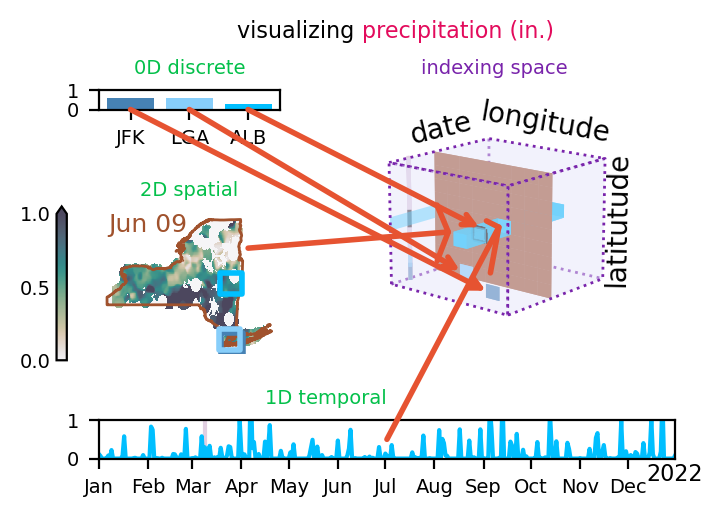

In [8]:
# draw shaded time stamps to mark time on zy plane
fig, axd = plt.subplot_mosaic([[ "bar", "cube"],
                              ["map", "cube"], 
                              ["ts", "ts"]], per_subplot_kw={"cube":{"projection":'3d'}}, 
                              layout='compressed', height_ratios=[1,8,2],
                              width_ratios = [1,2], figsize=(3.5,3))
vox = hh.make_cube(dates, lons, lats, axd['cube'])
ln = hh.make_ts(df, axd['ts'])
bars = hh.make_bars(df, axd["bar"])

nygeo, nyshp = hh.get_mapdata("nydata.csv", 's_22mr22.zip', airports['map_date'])
mp, im = hh.make_map(nygeo, nyshp, axd['map'])


axd['bar'].set_ylim(0, 1)
axd['ts'].set_ylim(0, 1)

# bar to coordinates
# x = longitude, y=time, z = latitude 
y = np.where(dates==airports['point_date'])[0][0]

for i, (station, lon, lat) in enumerate([("JFK", airports['jfk_lon'], airports['jfk_lat']), 
                                         ("LGA", airports['lga_lon'], airports['lga_lat']), 
                                         ("ALB", airports['t_lon'], airports['t_lat'])]):
    x = np.where(lons == lon)[0][0]
    z = np.where(lats == lat)[0][0]
    if i < 2:
        xadj = x
        yadj = y
        zadj = z+.5
    else:
        xadj = x+.5
        yadj = y
        zadj = z+1
    xrp, yrp, _ = proj3d.proj_transform(xadj, yadj, zadj, axd['cube'].get_proj())
    arr= mpatches.ConnectionPatch(xyA=(station, 0), xyB=(xrp, yrp), 
                                    coordsA='data', coordsB="data",
                                    axesA=axd['bar'], axesB=axd['cube'],
                                    arrowstyle ='->', color=pcd['functor'], lw=2)
    fig.add_artist(arr)
# map to plane

y = np.where(dates==airports['map_date'])[0][0]
xrp, yrp, _ =  proj3d.proj_transform(3, y-65, lats.size//2, axd['cube'].get_proj())
arr_map = mpatches.ConnectionPatch(xyA=(.825,.75), xyB=(xrp, yrp), 
                                   coordsA='axes fraction', coordsB="data", 
                                   axesA=axd['map'], axesB=axd['cube'], 
                                   arrowstyle='->', color=pcd['functor'], lw=2, mutation_aspect = 5)
fig.add_artist(arr_map)
                                   

y = dates.size//2 + 2
x = np.where(lons==airports['t_lon'])[0][0]
z = np.where(lats==airports['t_lat'])[0][0] + 1

xrp, yrp, _ =  proj3d.proj_transform(x, y, z, axd['cube'].get_proj())
#trans = mtransforms.blended_transform_factory(axd['ts'].transAxes, axd['ts'].transData)
arr_time = mpatches.ConnectionPatch(xyA=(.5, .5), xyB=(xrp,yrp), 
                                   coordsA="axes fraction", coordsB="data", 
                                   axesA=axd['ts'], axesB=axd['cube'], 
                                   arrowstyle='->', color=pcd['functor'], lw=2, mutation_aspect = 5)
fig.add_artist(arr_time)

for axn in ['ts', 'bar', 'map']:
    axd[axn].tick_params(labelsize=fs['script'])

#fig.suptitle(
#fig.suptitle("precipitation (in.)", size=fs['footnote'], x=.5, ha='left', color=pcd['fiber'])
yt = .9
fig.text(.5, yt, "visualizing ", size=fs['footnote'], ha='right', color='k')
fig.text(.5, yt, "precipitation (in.)", size=fs['footnote'], ha='left', color=pcd['fiber'])
axd['cube'].set_title("indexing space", color=pcd['base'], size=fs['footnote']-1)
axd['bar'].set_title("0D discrete", color=pcd['section'], size=fs['footnote']-1)
axd['ts'].set_title("1D temporal", color=pcd['section'], size=fs['footnote']-1, ha='right')
axd['map'].set_title("2D spatial", color=pcd['section'], size=fs['footnote']-1)


fig.savefig(paper_path/"k_different_types.pdf", dpi=300, bbox_inches='tight')

NameError: name 'jfk_color' is not defined

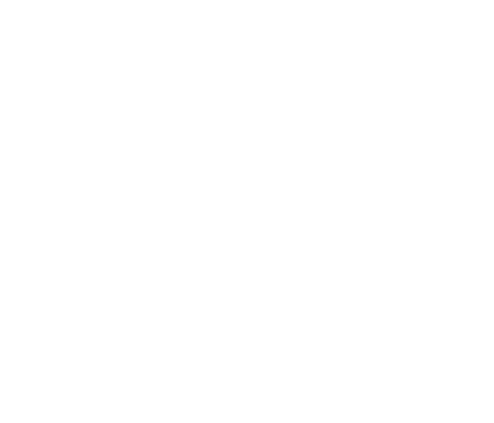

In [9]:

mosaic = [['pab','.', 'mab'], ['pa', '.', 'ma'], ['pac', '.', 'mac']]
fig, axd = plt.subplot_mosaic(mosaic, figsize=(3.5, 2), layout='compressed')
for axn in axd:
    if axn not in ['mac', 'mab']:
        axd[axn].set(xlim=(0,1), ylim=(0, 1), aspect='equal')
    
    axd[axn].set(xticks=[], yticks=[])   
    axd[axn].axis('off')


# visual
p1 = axd['pab'].text(.5, .5, f"({jfk_color}, {-1*jfk['LONGITUDE'].values[0]:.2f}, {jfk['LATITUDE'].values[0]: .2f})",color=pcd['section'], fontsize=fs['tiny'], ha='center', va='center')
pa1 = axd['pab'].annotate(r"$P_{a}\times square:P_{b}$",(.5, 1), xycoords=p1, ha='center', va='bottom', fontsize=fs['tiny'], color=pcd['fiber'])
p2 = axd['pa'].text(.5, .5, f"({jfk_color}, {-1*jfk['LONGITUDE'].values[0]:.2f}, {jfk['LATITUDE'].values[0]: .2f})",color=pcd['section'], fontsize=fs['tiny'], ha='center', va='center')
pa2 = axd['pa'].annotate(r"$color \times x \times Y:P_{a}$",(.5, 1), xycoords=p2, ha='center', va='bottom', fontsize=fs['tiny'], color=pcd['fiber'])
p3 = axd['pac'].text(.5, .5, f"({jfk_color}, {-1*jfk['LONGITUDE'].values[0]:.2f}, {jfk['LATITUDE'].values[0]: .2f})",color=pcd['section'], fontsize=fs['tiny'], ha='center', va='center')
pa3 = axd['pac'].annotate(r"$P_{a}\times circle:P_{c}$",(.5, 1), xycoords=p3, ha='center', va='bottom', fontsize=fs['tiny'], color=pcd['fiber'])



nygeo[nygeo['NAME']=='JFK INTL AP'].plot(marker ='s',edgecolor=jfk_color, facecolor='none', ax=axd['mab'], markersize=60, lw=2)
mp = nyshp.plot(ax=axd['mab'],  facecolor='none', edgecolor=(map_color, .2), lw=.25)
axd['mab'].margins(.2)

nygeo[nygeo['NAME']=='JFK INTL AP'].plot(marker ='o',edgecolor=jfk_color, facecolor='none', ax=axd['mac'], markersize=60, lw=2)
mp = nyshp.plot(ax=axd['mac'],  facecolor='none', edgecolor=(map_color, .2), lw=.25)
axd['mac'].margins(.2)

measure = axd['ma'].text(.5, .5, f"{mcolors.to_hex(jfk_color)},\n origin:(0,0), \n xy: ({-1*jfk['LONGITUDE'].values[0]:.2f}, {jfk['LATITUDE'].values[0]: .2f})", color=jfk_color, fontsize=fs['tiny'], ha='center', va='center')


arrowprops_art=dict(arrowstyle="->", color=pcd['artist'], lw=1.5, mutation_scale=15)
for i, (start, stop, label, ls, c) in enumerate([(p1, axd['mab'], r"$Q_{color, x,y, square}$", '-', pcd['artist']), (p2, axd['ma'], r"$\simeq$", ':', 'k'), (p3, axd['mac'], r"$Q_{color, x, y}$", '-', pcd['artist'])]):
    arrowprops_art['linestyle'] = ls
    arrowprops_art['color'] = c
    nu = mtext.Annotation("", xytext=(1, .5), xy=(0, .5), textcoords=start, xycoords=stop, arrowprops=arrowprops_art)
    fig.add_artist(nu)
    nu_lab = mtext.Annotation(label, xy=(.45, .75), xycoords=nu, color=pcd['artist'], fontsize=fs['tiny'], ha='center', va='bottom')
    fig.add_artist(nu_lab)

arrowprops_art=dict(arrowstyle="->", color=pcd['fiber'], lw=1.5, mutation_scale=15)
for (start, y1, stop, y2, label) in [(p1, 0, pa2, 1, r"$\pi_{P_{a}}$"), (pa3, 1, p2, 0, r"$\pi_{P_{a}}$")]:
    nu = mtext.Annotation("", xytext=(.5, y1), xy=(.5, y2), textcoords=start, xycoords=stop, arrowprops=arrowprops_art)
    fig.add_artist(nu)
    nu_lab = mtext.Annotation(label, xy=(.3, .5), xycoords=nu, color=pcd['fiber'], fontsize=fs['tiny'], ha='right', va='center')
    fig.add_artist(nu_lab)



arrowprops_art=dict(arrowstyle="->", color=pcd['monoid'], lw=1.5, mutation_scale=15)
for (start, y1, stop, y2, label) in [(axd['mab'], .25, measure , 1, r"$M|_{P_a}\circ\delta_{P_a, square}$"), (axd['mac'], .75, measure, 0, r"$M|_{P_a}\circ\delta_{P_a, circle}$")]:
    nu = mtext.Annotation("", xytext=(.5, y1), xy=(.5, y2), textcoords=start, xycoords=stop, arrowprops=arrowprops_art)
    fig.add_artist(nu)
    nu_lab = mtext.Annotation(label, xy=(.4, .5), xycoords=nu, color=pcd['monoid'], fontsize=fs['tiny'], ha='right', va='center')
    fig.add_artist(nu_lab)

In [ ]:
date = pd.to_datetime(airports['point_date'])

In [ ]:
date.year